In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [3]:
train_data.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [4]:
pd.unique(train_data[['Sex', 'SmokingStatus']].values.ravel('K'))

array(['Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes'],
      dtype=object)

In [5]:
def distribution(feature):
    plt.figure()
    sns.distplot(train_data[feature])
    print("Max value of {} is:  {:.2f} \nMin value of {} is:  {:.2f}\nMean of {} is: {:.2f}\nStandard Deviation of {} is:{:.2f}"\
      .format(feature,train_data[feature].max(),feature,train_data[feature].min(),feature,train_data[feature].mean(),feature,train_data[feature].std()))

Max value of FVC is:  6399.00 
Min value of FVC is:  827.00
Mean of FVC is: 2690.48
Standard Deviation of FVC is:832.77


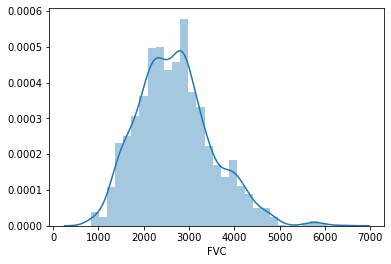

In [6]:
distribution("FVC")

Max value of Age is:  88.00 
Min value of Age is:  49.00
Mean of Age is: 67.19
Standard Deviation of Age is:7.06


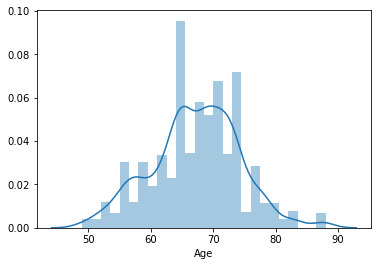

In [7]:
distribution("Age")

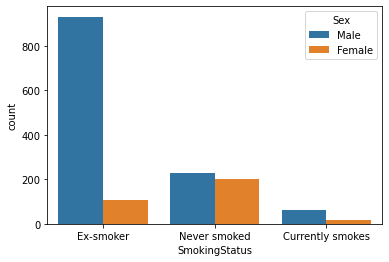

In [8]:
plt.figure()
sns.countplot(data=train_data,x='SmokingStatus',hue='Sex');

In [9]:
def distribution2(feature):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    for i in train_data.Sex.unique():
        sns.distplot(train_data[train_data['Sex']==i][feature],label=i)
    plt.title(f"Distribution of {feature} based on Sex")
    plt.legend()

    plt.subplot(122)
    for i in train_data.SmokingStatus.unique():
        sns.distplot(train_data[train_data['SmokingStatus']==i][feature],label=i)
    plt.title(f"Distribution of {feature}  based on Smoking Status")
    plt.legend()

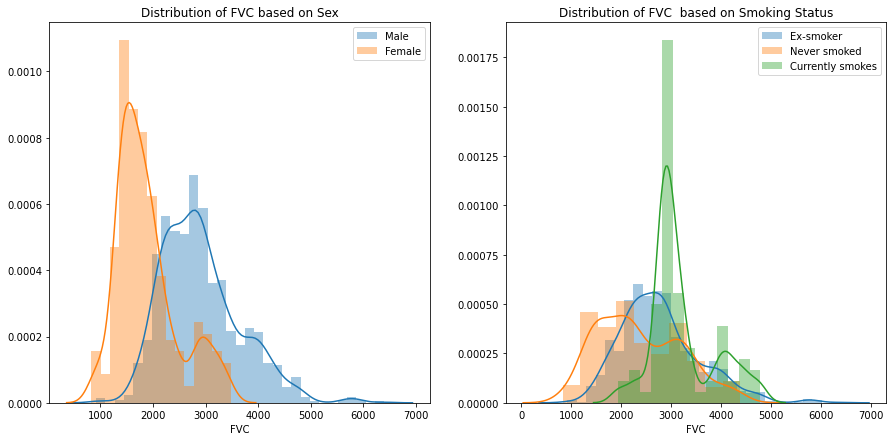

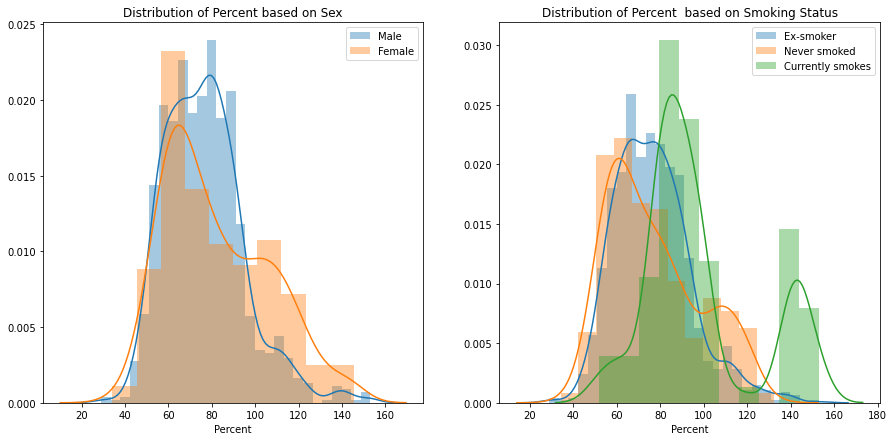

In [10]:
distribution2("FVC")
distribution2("Percent")